<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tic-Toc-Toe-environment" data-toc-modified-id="Tic-Toc-Toe-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tic Toc Toe environment</a></span><ul class="toc-item"><li><span><a href="#Initialization-and-attributes" data-toc-modified-id="Initialization-and-attributes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialization and attributes</a></span></li><li><span><a href="#Taking-actions" data-toc-modified-id="Taking-actions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Taking actions</a></span></li><li><span><a href="#Reward" data-toc-modified-id="Reward-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Reward</a></span></li></ul></li><li><span><a href="#Optimal-policy-for-Tic-Toc-Toe-environment" data-toc-modified-id="Optimal-policy-for-Tic-Toc-Toe-environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimal policy for Tic Toc Toe environment</a></span><ul class="toc-item"><li><span><a href="#An-example-of-optimal-player-playing-against-random-player" data-toc-modified-id="An-example-of-optimal-player-playing-against-random-player-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example of optimal player playing against random player</a></span></li><li><span><a href="#An-example-of-optimal-player-playing-against-optimal-player" data-toc-modified-id="An-example-of-optimal-player-playing-against-optimal-player-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>An example of optimal player playing against optimal player</a></span></li></ul></li><li><span><a href="#Performance-measures" data-toc-modified-id="Performance-measures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance measures</a></span></li></ul></div>

In [1]:
# std
import random
from typing import List, Dict

# imported
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# customized
from tic_env import TictactoeEnv, OptimalPlayer

random.seed(2020)

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

## Initialization and attributes

You can initialize the environment / game as following:

In [24]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [25]:
env.render()

|- - -|
|- - -|
|- - -|



## Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [26]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [27]:
env.render()

|- - X|
|- - -|
|- - -|



In [28]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [29]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [30]:
env.render()

|- - X|
|- O -|
|- - -|



In [31]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [11]:
# env.step((0,2))

## Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [32]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [33]:
env.reward(player='X')

0

In [34]:
env.reward(player='O')

0

An example of finishing the game:

In [35]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [23]:
env.render()

|X X X|
|O O -|
|- - -|



In [24]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [25]:
env.reward(player='X')

1

In [26]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [27]:
env.reset();

In [28]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [29]:
opt_player.act(env.grid)

(2, 2)

In [30]:
opt_player.player

'X'

In [ ]:
env.reset()

## An example of optimal player playing against random player

In [14]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player = O
Random player = X
|O X X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X - O|
|X X -|
|X O O|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|- - O|
|- O X|
|O X X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - -|
|- O X|
|X X O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X O -|
|- X O|
|- - X|



## An example of optimal player playing against optimal player

In [56]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|O O X|
|X X O|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|O X X|
|X O O|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O X X|
|X O O|



# Performance measures

In [2]:
def run_episode(agent1, agent2, env, switch: bool):
    grid, end, __  = env.observe()
    if switch:
        agent1.player, agent2.player = 'O', 'X'
    else:
        agent1.player, agent2.player = 'X', 'O'
    while end == False:
        if env.current_player == agent1.player:
            move = agent1.act(grid) 
            grid, end, winner = env.step(move, print_grid=False) 
        else:
            move = agent2.act(grid)
            grid, end, winner = env.step(move, print_grid=False) 
    return winner, agent1, agent2

In [3]:
def eval(agent1, agent2, n_episode: int = 500) -> Dict:
    env = TictactoeEnv()
    win, los, draw = 0, 0, 0
    res = []
        
    for episode in range(n_episode):
        env.reset()
        switch = i % 2
        winner, agent1, agent2 = run_episode(agent1, agent2, env, switch)

        if winner == agent1.player:
            win += 1
            res.append(1)
        elif winner == agent2.player:
            los += 1
            res.append(-1)
        else:
            draw += 1
            res.append(0)
    
    res_info = {
        'win': win,
        'los': los,
        'draw': draw,
        'res': res,
        'metric': (win-los)/n_episode, 
        'draw_rate': draw/n_episode
    }
           
    return res_info

In [30]:
metric_dict = {'opt': 0.0, 'rand': 1.0}
for (mode, epsilon) in metric_dict.items():
    player_opt = OptimalPlayer(epsilon=0.)
    player_baseline = OptimalPlayer(epsilon=epsilon)
    res_info = eval(player_opt, player_baseline)
    
    print("# Eval with Opt({})".format(epsilon))
    print('M{} = {}, Draw rate = {}'.format(mode, res_info['metric'], res_info['draw_rate']))

100%|████████████████████████████████████████████████| 500/500 [00:02<00:00, 219.48it/s]


# Eval with Opt(0.0)
Mopt = 0.0, Draw rate = 1.0


100%|████████████████████████████████████████████████| 500/500 [00:01<00:00, 448.57it/s]

# Eval with Opt(1.0)
Mrand = 0.974, Draw rate = 0.026


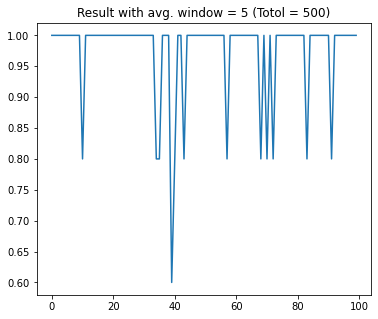

In [31]:
def res_plot(epi_res: List, window: int = 250) -> None:
    results = np.mean(np.array(epi_res).reshape(-1,window), axis=1)
    fig, axes = plt.subplots(figsize=(6, 5))
    axes.plot(results)
    axes.set_title('Result with avg. window = {} (Totol = {})'.format(window, len(epi_res)))
    
epi_res = res_info['res']
res_plot(epi_res, window=5)

# 2. Q Learning

In [4]:
from q_player import QPlayer

## 2.1 Learning from experts

In [5]:
env = TictactoeEnv()

Turns_odd = np.array(["X", "O"])
Turns_even = np.array(["O", "X"])
epsilon = 0.5
player_qlearning = QPlayer(player="X", epsilon_min=epsilon, epsilon_max=epsilon)

record_inter = 250
reward_record = []
avg_reward_record = {}

for i in tqdm(range(20000)):
    env.reset()
    grid, end, winner = env.observe()
    if i % 2 == 0:
        Turns = Turns_odd
    else:
        Turns = Turns_even
    player_opt_for_train = OptimalPlayer(epsilon=0.5, player=Turns[0])
    player_qlearning.player = Turns[1]

    while not end:
        if env.current_player == player_qlearning.player:
            move = player_qlearning.act(grid)
        else:
            move = player_opt_for_train.act(grid)

        grid, end, winner = env.step(move, print_grid=False)
        reward = env.reward(player_qlearning.player)

        special_case = np.sum(grid == 1) == 1 and np.sum(grid == 0) == 8
        if (env.current_player == player_qlearning.player or end) and not special_case:
            player_qlearning.update_q(
                reward=reward,
                grid=grid,
                is_end=end,
            )

        if end:
            reward_record.append(env.reward(player=player_qlearning.player))

            if ((i + 1) % record_inter == 0) & (i != 0):
                avg_reward_record.update({i + 1: np.mean(reward_record)})
                reward_record = []


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:38<00:00, 521.88it/s]


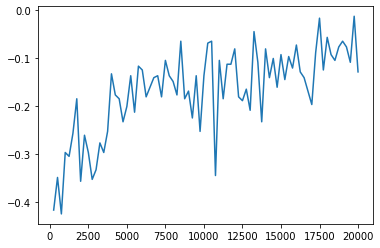

In [6]:
game_idx = list(avg_reward_record.keys())
avg_rewards = list(avg_reward_record.values())

plt.plot(game_idx,avg_rewards)
# plt.savefig("s.png")

### 2.1.1 Decreasing exploration

In [15]:
env = TictactoeEnv()
Turns_odd = np.array(["X", "O"])
Turns_even = np.array(["O", "X"])

player_opt = OptimalPlayer(epsilon=0)
player_rand = OptimalPlayer(epsilon=1)

n_star_list = [1, 100, 10000, 20000, 40000]
avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for n_star in n_star_list:
    print("start training with n^star = {}".format(n_star))
    player_qlearning = QPlayer(
        player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star
    )

    record_inter = 250
    reward_record = []
    avg_reward_record = {}
    metrics_record = {"M_opt": {}, "M_rand": {}}

    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()
        if i % 2 == 0:
            Turns = Turns_odd
        else:
            Turns = Turns_even
        player_opt_for_train = OptimalPlayer(epsilon=0.5, player=Turns[0])
        player_qlearning.player = Turns[1]

        while not end:
            if env.current_player == player_qlearning.player:
                move = player_qlearning.act(grid, n=i + 1)
            else:
                move = player_opt_for_train.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(player_qlearning.player)

            special_case = np.sum(grid == 1) == 1 and np.sum(grid == 0) == 8
            if (
                env.current_player == player_qlearning.player or end
            ) and not special_case:
                player_qlearning.update_q(
                    reward=reward,
                    grid=grid,
                    is_end=end,
                )

            if end:
                reward_record.append(env.reward(player=player_qlearning.player))

                if ((i + 1) % record_inter == 0) & (i != 0):
                    avg_reward_record.update({i: np.mean(reward_record)})
                    reward_record = []

                    player_qlearning.epsilon_min = 0
                    player_qlearning.epsilon_max = 0
                    res_info = eval(player_qlearning, player_opt)
                    metrics_record["M_opt"].update({i + 1: res_info["metric"]})
                    res_info = eval(player_qlearning, player_rand)
                    metrics_record["M_rand"].update({i + 1: res_info["metric"]})
                    player_qlearning.epsilon_min = 0.1
                    player_qlearning.epsilon_max = 0.8

    avg_reward_record_dict.update({n_star: avg_reward_record})
    metrics_dict["M_opt"].update({n_star: metrics_record["M_opt"]})
    metrics_dict["M_rand"].update({n_star: metrics_record["M_rand"]})


start training with n^star = 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:01<00:00, 82.90it/s]


start training with n^star = 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.80it/s]


start training with n^star = 10000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:01<00:00, 82.89it/s]


start training with n^star = 20000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:05<00:00, 81.41it/s]


start training with n^star = 40000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:20<00:00, 76.73it/s]


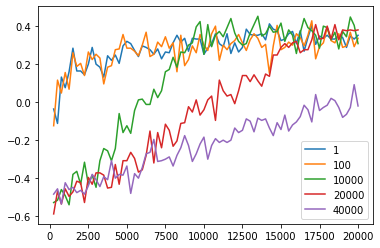

In [16]:
for n_star in n_star_list:
    game_idx = list(avg_reward_record_dict[n_star].keys())
    avg_rewards = list(avg_reward_record_dict[n_star].values())
    plt.plot(game_idx,avg_rewards,label = str(n_star))

plt.legend()
plt.show()

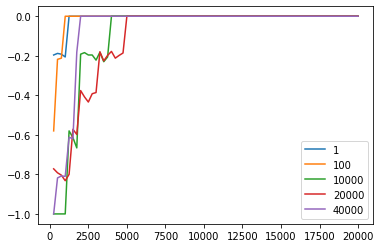

In [17]:
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_opt"][n_star].keys())
    avg_rewards = list(metrics_dict["M_opt"][n_star].values())
    plt.plot(game_idx,avg_rewards,label = str(n_star))

plt.legend()
plt.show()

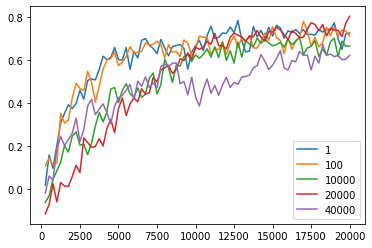

In [18]:
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_rand"][n_star].keys())
    avg_rewards = list(metrics_dict["M_rand"][n_star].values())
    plt.plot(game_idx,avg_rewards,label = str(n_star))

plt.legend()
plt.show()

### 2.1.2 Good experts and bad experts

In [20]:
env = TictactoeEnv()
Turns_odd = np.array(["X", "O"])
Turns_even = np.array(["O", "X"])

player_opt = OptimalPlayer(epsilon=0)
player_rand = OptimalPlayer(epsilon=1)

sample_number = 6
epsilon_expert_list = []
for i in range(sample_number):
    epsilon_expert_list.append(i/(sample_number-1))

best_n_star = 100
    
avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for epsilon_expert in epsilon_expert_list:
    print("start training with expert whose epsilton is {}".format(epsilon_expert))
    player_qlearning = QPlayer(
        player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=best_n_star
    )

    record_inter = 250
    reward_record = []
    avg_reward_record = {}
    metrics_record = {"M_opt": {}, "M_rand": {}}

    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()
        if i % 2 == 0:
            Turns = Turns_odd
        else:
            Turns = Turns_even
        player_opt_for_train = OptimalPlayer(epsilon=epsilon_expert, player=Turns[0])
        player_qlearning.player = Turns[1]

        while not end:
            if env.current_player == player_qlearning.player:
                move = player_qlearning.act(grid, n=i + 1)
            else:
                move = player_opt_for_train.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(player_qlearning.player)

            special_case = np.sum(grid == 1) == 1 and np.sum(grid == 0) == 8
            if (
                env.current_player == player_qlearning.player or end
            ) and not special_case:
                player_qlearning.update_q(
                    reward=reward,
                    grid=grid,
                    is_end=end,
                )

            if end:
                reward_record.append(env.reward(player=player_qlearning.player))

                if ((i + 1) % record_inter == 0) & (i != 0):
                    avg_reward_record.update({i: np.mean(reward_record)})
                    reward_record = []

                    player_qlearning.epsilon_min = 0
                    player_qlearning.epsilon_max = 0
                    res_info = eval(player_qlearning, player_opt)
                    metrics_record["M_opt"].update({i + 1: res_info["metric"]})
                    res_info = eval(player_qlearning, player_rand)
                    metrics_record["M_rand"].update({i + 1: res_info["metric"]})
                    player_qlearning.epsilon_min = 0.1
                    player_qlearning.epsilon_max = 0.8

    avg_reward_record_dict.update({epsilon_expert: avg_reward_record})
    metrics_dict["M_opt"].update({epsilon_expert: metrics_record["M_opt"]})
    metrics_dict["M_rand"].update({epsilon_expert: metrics_record["M_rand"]})


start training with expert whose epsilton is 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:38<00:00, 71.91it/s]


start training with expert whose epsilton is 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:15<00:00, 78.35it/s]


start training with expert whose epsilton is 0.4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:52<00:00, 86.18it/s]


start training with expert whose epsilton is 0.6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:41<00:00, 90.36it/s]


start training with expert whose epsilton is 0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:09<00:00, 105.64it/s]


start training with expert whose epsilton is 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:51<00:00, 116.32it/s]


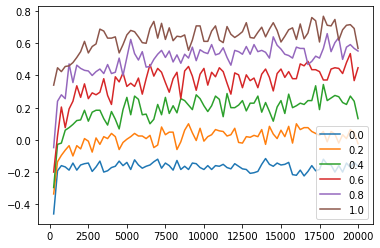

In [21]:
for epsilon_expert in epsilon_expert_list:
    game_idx = list(avg_reward_record_dict[epsilon_expert].keys())
    avg_rewards = list(avg_reward_record_dict[epsilon_expert].values())
    plt.plot(game_idx,avg_rewards,label = str(epsilon_expert))

plt.legend()
plt.show()

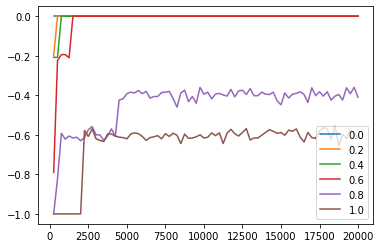

In [22]:
for epsilon_expert in epsilon_expert_list:
    game_idx = list(metrics_dict["M_opt"][epsilon_expert].keys())
    avg_rewards = list(metrics_dict["M_opt"][epsilon_expert].values())
    plt.plot(game_idx,avg_rewards,label = str(epsilon_expert))

plt.legend()
plt.show()

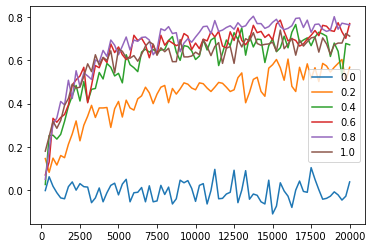

In [23]:
for epsilon_expert in epsilon_expert_list:
    game_idx = list(metrics_dict["M_rand"][epsilon_expert].keys())
    avg_rewards = list(metrics_dict["M_rand"][epsilon_expert].values())
    plt.plot(game_idx,avg_rewards,label = str(epsilon_expert))

plt.legend()
plt.show()

## 2.2 Learning by self-practice

### learning with fixed epsilon

In [44]:
env = TictactoeEnv()

player_opt = OptimalPlayer(epsilon=0)
player_rand = OptimalPlayer(epsilon=1)

sample_number = 6
epsilon_list = []
for i in range(sample_number):
    epsilon_list.append(i / (sample_number - 1))

avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for epsilon in epsilon_list:
    print("start training with epsilton = {}".format(epsilon))
    player_qlearning1 = QPlayer(player="X", epsilon_min=epsilon, epsilon_max=epsilon)
    player_qlearning2 = QPlayer(player="O", epsilon_min=epsilon, epsilon_max=epsilon)
    player_qlearning_eval = QPlayer(player="X", epsilon_min=0, epsilon_max=0)
    # link the q_tables of all player
    player_qlearning2.q_table = player_qlearning1.q_table
    player_qlearning_eval.q_table = player_qlearning1.q_table

    record_inter = 250
    metrics_record = {"M_opt": {}, "M_rand": {}}

    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()

        while not end:
            if env.current_player == player_qlearning1.player:
                move = player_qlearning1.act(grid)
            elif env.current_player == player_qlearning2.player:
                move = player_qlearning2.act(grid)
            else:
                raise Exception("none of the player is match!")

            grid, end, winner = env.step(move, print_grid=False)
            reward1 = env.reward(player_qlearning1.player)
            reward2 = env.reward(player_qlearning2.player)

            special_case = np.sum(grid == 1) == 1 and np.sum(grid == 0) == 8
            if special_case:
                continue
            elif env.current_player == player_qlearning1.player:
                player_qlearning1.update_q(
                    reward=reward1,
                    grid=grid,
                    is_end=end,
                )
                if end:
                    player_qlearning2.update_q(
                        reward=reward2,
                        grid=grid,
                        is_end=end,
                    )
            else:
                player_qlearning2.update_q(
                    reward=reward2,
                    grid=grid,
                    is_end=end,
                )
                if end:
                    player_qlearning1.update_q(
                        reward=reward1,
                        grid=grid,
                        is_end=end,
                    )

            if end:
                if ((i + 1) % record_inter == 0) & (i != 0):
                    res_info = eval(player_qlearning_eval, player_opt)
                    metrics_record["M_opt"].update({i + 1: res_info["metric"]})
                    res_info = eval(player_qlearning_eval, player_rand)
                    metrics_record["M_rand"].update({i + 1: res_info["metric"]})

    metrics_dict["M_opt"].update({epsilon: metrics_record["M_opt"]})
    metrics_dict["M_rand"].update({epsilon: metrics_record["M_rand"]})


start training with epsilton = 0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:08<00:00, 106.27it/s]


start training with epsilton = 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:29<00:00, 95.48it/s]


start training with epsilton = 0.4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:45<00:00, 88.52it/s]


start training with epsilton = 0.6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:20<00:00, 99.54it/s]


start training with epsilton = 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:35<00:00, 92.86it/s]


start training with epsilton = 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:13<00:00, 103.36it/s]


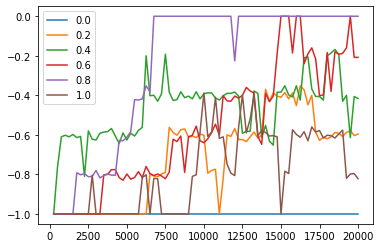

In [45]:
for epsilon in epsilon_list:
    game_idx = list(metrics_dict["M_opt"][epsilon].keys())
    avg_rewards = list(metrics_dict["M_opt"][epsilon].values())
    plt.plot(game_idx,avg_rewards,label = str(epsilon))

plt.legend()
plt.show()

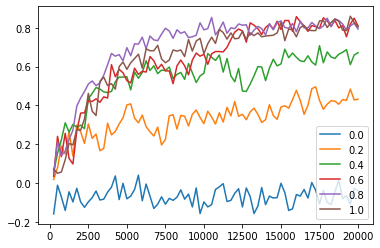

In [46]:
for epsilon in epsilon_list:
    game_idx = list(metrics_dict["M_rand"][epsilon].keys())
    avg_rewards = list(metrics_dict["M_rand"][epsilon].values())
    plt.plot(game_idx,avg_rewards,label = str(epsilon))

plt.legend()
plt.show()

### Learning with decreasing exploration

In [47]:
env = TictactoeEnv()

player_opt = OptimalPlayer(epsilon=0)
player_rand = OptimalPlayer(epsilon=1)

n_star_list = [1, 100, 10000, 20000, 40000]

avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for n_star in n_star_list:
    print("start training with n_star = {}".format(n_star))
    player_qlearning1 = QPlayer(
        player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star
    )
    player_qlearning2 = QPlayer(
        player="O", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star
    )
    player_qlearning_eval = QPlayer(player="X", epsilon_min=0, epsilon_max=0)
    # link the q_tables of all player
    player_qlearning2.q_table = player_qlearning1.q_table
    player_qlearning_eval.q_table = player_qlearning1.q_table

    record_inter = 250
    metrics_record = {"M_opt": {}, "M_rand": {}}

    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()

        while not end:
            if env.current_player == player_qlearning1.player:
                move = player_qlearning1.act(grid, n=i + 1)
            elif env.current_player == player_qlearning2.player:
                move = player_qlearning2.act(grid, n=i + 1)
            else:
                raise Exception("none of the player is match!")

            grid, end, winner = env.step(move, print_grid=False)
            reward1 = env.reward(player_qlearning1.player)
            reward2 = env.reward(player_qlearning2.player)

            special_case = np.sum(grid == 1) == 1 and np.sum(grid == 0) == 8
            if special_case:
                continue
            elif env.current_player == player_qlearning1.player:
                player_qlearning1.update_q(
                    reward=reward1,
                    grid=grid,
                    is_end=end,
                )
                if end:
                    player_qlearning2.update_q(
                        reward=reward2,
                        grid=grid,
                        is_end=end,
                    )
            else:
                player_qlearning2.update_q(
                    reward=reward2,
                    grid=grid,
                    is_end=end,
                )
                if end:
                    player_qlearning1.update_q(
                        reward=reward1,
                        grid=grid,
                        is_end=end,
                    )

            if end:
                if ((i + 1) % record_inter == 0) & (i != 0):
                    res_info = eval(player_qlearning_eval, player_opt)
                    metrics_record["M_opt"].update({i + 1: res_info["metric"]})
                    res_info = eval(player_qlearning_eval, player_rand)
                    metrics_record["M_rand"].update({i + 1: res_info["metric"]})

    metrics_dict["M_opt"].update({n_star: metrics_record["M_opt"]})
    metrics_dict["M_rand"].update({n_star: metrics_record["M_rand"]})


start training with n_star = 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:19<00:00, 100.30it/s]


start training with n_star = 100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:15<00:00, 102.46it/s]


start training with n_star = 10000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:20<00:00, 99.86it/s]


start training with n_star = 20000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:23<00:00, 98.41it/s]


start training with n_star = 40000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:14<00:00, 102.95it/s]


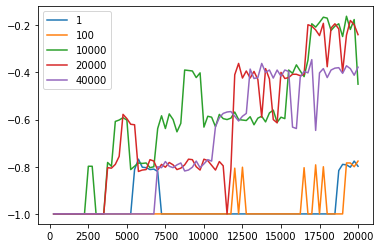

In [54]:
max_M_opt = 0
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_opt"][n_star].keys())
    avg_rewards = list(metrics_dict["M_opt"][n_star].values())
    if max_M_opt < max(avg_rewards):
        max_M_opt = max(avg_rewards)
    plt.plot(game_idx,avg_rewards,label = str(n_star))

plt.legend()
plt.show()

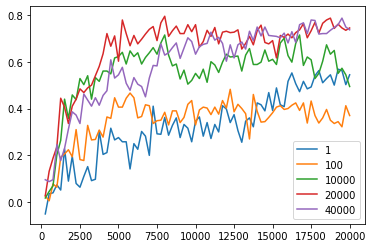

In [55]:
max_M_rand = 0
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_rand"][n_star].keys())
    avg_rewards = list(metrics_dict["M_rand"][n_star].values())
    if max_M_rand < max(avg_rewards):
        max_M_rand = max(avg_rewards)
    plt.plot(game_idx,avg_rewards,label = str(n_star))

plt.legend()
plt.show()

In [56]:
print("highest M_opt is {}".format(max_M_opt))
print("highest M_rand is {}".format(max_M_rand))

highest M_opt is 0
highest M_rand is 0.794


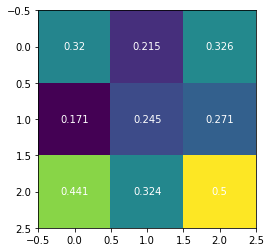

In [85]:
# Visualize Q-values
state = (0,0,0,0,0,0,0,0,0)
q_table_initial = np.zeros((3,3))
for action in list(player_qlearning_eval.q_table[state].keys()):
    q_table_initial[action//3, action%3] = player_qlearning_eval.q_table[state][action]

fig, ax = plt.subplots()
im = ax.imshow(q_table_initial)

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(q_table_initial[i, j],3),
                       ha="center", va="center", color="w")

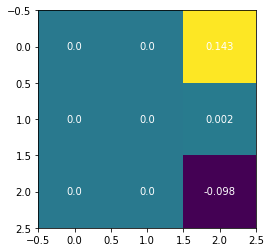

In [84]:
state = (1,1,0,-1,-1,0,0,0,0)
q_table_win = np.zeros((3,3))
for action in list(player_qlearning_eval.q_table[state].keys()):
    q_table_win[action//3, action%3] = player_qlearning_eval.q_table[state][action]

fig, ax = plt.subplots()
im = ax.imshow(q_table_win)

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(q_table_win[i, j],3),
                       ha="center", va="center", color="w")

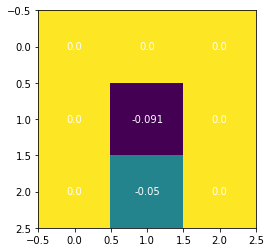

In [86]:
state = (1,1,0,-1,0,0,0,0,0)
q_table_lose = np.zeros((3,3))
for action in list(player_qlearning_eval.q_table[state].keys()):
    q_table_lose[action//3, action%3] = player_qlearning_eval.q_table[state][action]

fig, ax = plt.subplots()
im = ax.imshow(q_table_lose)

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(q_table_lose[i, j],3),
                       ha="center", va="center", color="w")